## <font color='blue'>**Recurrent Neural Networks - why and where to use?**</font>

Neural network types like **fully connected networks or convolutional neural networks are good at identifying patterns in data but they do not have a memory.**
But there are situations where remembering state information about previously seen examples can help get better results. **Let's say for the natural language processing task of text generation, if our network can remember some state information about words seen, then it can help to generate new better words as it now knows about the context of the sentence.** This kind of approach can help with time-series data as well where new prediction is generally dependent on the last few text examples.

To solve the problem of maintaining memory, RNNs and LSTMs were introduced. They maintain the state of the data examples and use it to improve results.

Pytorch rnn layers ---->
nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

## <font color='blue'>**Contents**</font>

### **1. Populate Vocabulary**
1.1 Load Dataset

1.2 Create Tokenizer And Create Vocab

### **2. RNN for Text Classification**
2.1 Create Data Loaders

2.2 Define RNN Layers

2.3 Train Network

2.4 Evaluate Network Performance


In [ ]:
!pip -q install portalocker

torchtext --- > The torchtext package consists of data processing utilities and popular datasets for natural language.

https://pytorch.org/text/stable/index.html

In [ ]:
import torch
from torch.utils.data import DataLoader
# Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

import torchtext
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

## <font color='red'>**Load Dataset**</font>

We are loading AG NEWS dataset from datasets sub-module of torchtext library. The dataset is already divided into the train (120000 text examples) and test (7600 text examples) sets.

https://pytorch.org/text/0.11.0/datasets.html

In [ ]:
train_dataset, test_dataset = torchtext.datasets.AG_NEWS(root='.data', split=('train', 'test'))

In [ ]:
train_dataset

ShardingFilterIterDataPipe

In [ ]:
# Convert iterable-style dataset to map-style dataset - https://pytorch.org/text/stable/data_functional.html#to-map-style-dataset

# train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)
# print(train_dataset[0])

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

# for batch in train_loader:
#     labels, texts =batch[0], batch[1]
#     print(labels)
#     print(texts)
#     break

## <font color='red'>**Populate Vocabulary**</font>

We first defined a tokenizer using **get_tokenizer()** from the torchtext library's data sub-module. This **tokenizer takes a text example and returns a list of tokens, including words, punctuation marks, and special symbols.**

Then, we created a vocabulary using **build_vocab_from_iterator()** from the vocab sub-module. We defined an iterator function called **build_vocabulary()** that iterates through datasets, yielding token lists for each text example. Unknown tokens are mapped to a special character at index 0.

https://pytorch.org/text/stable/vocab.html

https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator

In [ ]:
tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, test_dataset]), min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [ ]:
len(vocab)

98635

In [ ]:
print(vocab.get_itos()[:10])

['<UNK>', '.', 'the', ',', 'to', 'a', 'of', 'in', 'and', 's']


In [ ]:
print(vocab.get_stoi())

{'zygmunt': 98631, 'zwiki': 98630, 'zvidauri': 98628, 'zurine': 98626, 'zurab': 98624, 'zuo': 98623, 'zuloaga': 98622, 'zovko': 98615, 'zotinca': 98614, 'zos': 98613, 'zoroastrianism': 98612, 'zorba': 98611, 'zoology': 98608, 'zooks': 98607, 'zoo\\as': 98605, 'zonta': 98604, 'zoner': 98603, 'zone-h': 98601, 'zombi': 98600, 'zoll': 98599, 'zolecki': 98598, 'zogby\\\\&lt': 98597, 'zoeller': 98596, 'zoch': 98595, 'zocalo': 98594, 'ziyang': 98593, 'zircons': 98591, 'zirconium': 98590, 'zipping': 98589, 'zinter': 98588, 'zinged': 98587, 'zimbabwe*s': 98585, 'zih-droo': 98583, 'zigbee--a': 98581, 'zif': 98578, 'zico': 98577, 'ziadi': 98576, 'zhukov\\said': 98575, 'zhiguli': 98573, 'zhaohui': 98571, 'zeynep': 98570, 'zew/cpi': 98569, 'zervos': 98566, 'zero-grav': 98561, 'zero-energy': 98560, 'zero-day': 98559, 'zeppieri': 98558, 'zemann': 98550, 'zeitoun': 98549, 'zealand-based': 98543, 'zdravco': 98541, 'zawodny': 98539, 'zatloukal': 98535, 'zastrossi': 98534, 'zarya': 98533, 'zarqawis': 985

In [ ]:
tokens = tokenizer("Hello how are you?, Welcome to CoderzColumn!!")
indexes = vocab(tokens)

tokens, indexes

(['hello',
  'how',
  'are',
  'you',
  '?',
  ',',
  'welcome',
  'to',
  'coderzcolumn',
  '!',
  '!'],
 [12388, 355, 42, 164, 80, 3, 3298, 4, 0, 747, 747])

In [ ]:
vocab["<UNK>"]

0

## <font color='red'>**Create Data Loaders**</font>

Below, we've loaded the AG NEWS dataset and created data loaders for training, enabling batch processing. These loaders yield batches of **1024** examples along with their corresponding target labels.

To vectorize text examples within each batch, we've implemented a function called **vectorize_batch()**. This function tokenizes text, generates indexes using the vocabulary, and returns these indexes as torch tensors alongside target labels. We've limited the token size to 25 tokens per example; longer examples are truncated, while shorter ones are padded with 0s. Both data loaders utilize this vectorization function via the collate_fn parameter.

In [ ]:
# train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 25

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]


train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [ ]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


## <font color='red'>**RNN Layers**</font>

In this section, we have created a **recurrent neural network** that we'll be using for the **text classification task**. The network consists of 3 layers - **Embeddings layer, RNN layer and Linear layer**

The **embedding layer** has word embeddings for each token/word of our dictionary. We have set an embedding length of 50 for our example. This means that the embedding layer will have the weight of shape (len_vocab, 50). It has an embedding vector of length 50 for each token of our vocabulary. The embedding layer simply maps input indexes to a list of embeddings. Our data loaders will be returning indexes for tokens of text examples which will be given to the embedding layer as input which will convert indexes to embeddings. These embeddings will be updated during training to better classify documents. The input of the embedding layer will be of shape (batch_size, 25) and the output will be (batch_size, 25, 50), The batch size in our case is 1024.

The **RNN layer** will take input from embedding layer of shape (batch_size, max_tokens, embedding_length) = (batch_size, 25, 50), perform it's operations and return an output of shape (batch_size, max_tokens, hidden_size) = (batch_size, 25, 50). In our case, the output shape of RNN layer is 50. If for example the hidden size of a recurrent layer is set at 75 then output from the recurrent layer will be of shape (batch_size, 25, 75). The recurrent layer loops through embeddings of tokens for each text example and generates output that has some knowledge about the context of the text documents. When calling the recurrent layer in the forward pass, we need to provide initial state detail to it which we have provided as random numbers. An initial state is needed for each text example. If we don't provide it then PyTorch generates a tensor of zeros internally. In our case, we have provided random numbers of shape (1, batch_size, 50) which means for each text example we have provided a real-valued vector of length 50 as an initial state.

We can create recurrent layer using RNN() constructor available from 'nn' sub-module of torch library. We need to provide input shape and hidden dimension size to the constructor. We can create multiple RNN layers by providing an integer value greater than 1 to num_layers parameter. By default, the output shape of RNN layer will be (25, batch_size, 50) but we have converted it to (batch_size, 25, 50) by setting batch_first parameter to True.

The output of RNN will be given to the **linear layer** which has 4 output units (same as a number of target classes). We have given the last output of each example (output[:,-1]) in our case to the linear layer because the RNN layer generates output for each 25 tokens of the text example. We only need to give the last output of each example to be given as input to the linear layer as according to the concept of RNN, it has information about all previous tokens. So, even though the output of RNN layer is of shape (batch_size, 25, 50), the input to the linear layer will be (batch_size, 50) because we'll take the last entry from 25 entries for each example.

In [ ]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
n_layers= 1

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim))
        return self.linear(output[:,-1])

In [ ]:
rnn_classifier = RNNClassifier()
rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(98635, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [ ]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98635, 50)
Parameters : 
torch.Size([98635, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



In [ ]:
# out = rnn_classifier(torch.randint(0, len(vocab), (1024, max_words)))
# out.shape

torch.Size([1024, 4])

## <font color='red'>**RNN Training**</font>

we are training our network using data loaders. We have created a helper function for the training network. The function takes **model, loss function, optimizer, train data loader, validation data loader, and a number of epochs as input.** It then performs a training loop number of epochs times. For each epoch, it loops through training data in batches using a train data loader. For each batch of data, it performs a forward pass to make predictions, calculates loss value (using predictions and actual target labels), calculates gradients, and updates network parameters using gradients. It also records the loss value for each batch and prints the average loss at the end of each epoch. We have also created another helper function that loops through the validation data loader and calculates validation accuracy and loss.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

Below, we have initialized the necessary parameters and trained our network using a function defined in the previous cell. We have initialized a number of epochs to 15 and the learning rate to 0.001. Then, we have initialized the loss function, our classification network, and Adam optimizer. At last, we have called our training routine with the necessary parameters to perform training. We can notice from the loss and accuracy value getting printed after each epoch that our model is doing a good job at the text classification task.

In [ ]:
from torch.optim import Adam

epochs = 5
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:10<00:00, 11.25it/s]


Train Loss : 1.349
Valid Loss : 1.214
Valid Acc  : 0.462


100%|██████████| 118/118 [00:08<00:00, 13.94it/s]


Train Loss : 0.980
Valid Loss : 0.800
Valid Acc  : 0.686


100%|██████████| 118/118 [00:08<00:00, 14.19it/s]


Train Loss : 0.683
Valid Loss : 0.630
Valid Acc  : 0.764


100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


Train Loss : 0.545
Valid Loss : 0.545
Valid Acc  : 0.807


100%|██████████| 118/118 [00:08<00:00, 13.63it/s]


Train Loss : 0.465
Valid Loss : 0.497
Valid Acc  : 0.827


## <font color='red'>**Evaluate Network Performance**</font>

In this section, we have evaluated the performance of our network by calculating **accuracy, classification report** (precision, recall, and f1-score per target class) and **confusion matrix metrics** on test predictions. We can notice from the accuracy that our model has done a decent job at classifying text documents of the test dataset.

In [ ]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes, digits=3))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8257894736842105

Classification Report : 
              precision    recall  f1-score   support

       World      0.824     0.855     0.839      1900
      Sports      0.895     0.919     0.907      1900
    Business      0.782     0.793     0.788      1900
    Sci/Tech      0.799     0.736     0.766      1900

    accuracy                          0.826      7600
   macro avg      0.825     0.826     0.825      7600
weighted avg      0.825     0.826     0.825      7600


Confusion Matrix : 
[[1624   94  101   81]
 [  80 1747   30   43]
 [ 122   44 1507  227]
 [ 146   68  288 1398]]


In [ ]:
!pip -q install scikit-plot

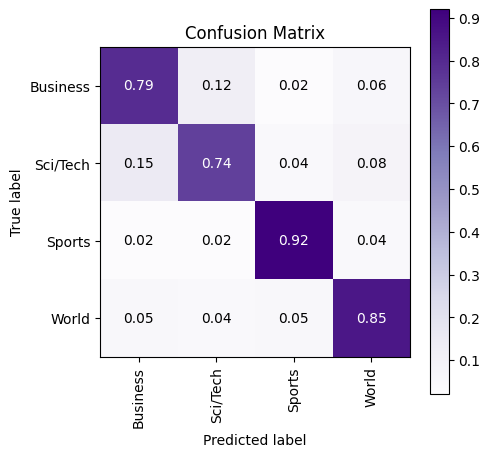

In [ ]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);